In [1]:
import itertools

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib import pyplot as plt

In [2]:
# Due to the dependencies on other packages, gammapy v0.19 is installed
# in the current magic-cta-pipe environment, but it is already outdated.
# In order to use the latest features, such as dynamic theta cuts and
# the wobble region finder, please run this notebook with a different
# environment where the newer versions of gammapy (v0.20.*) is installed.

import gammapy

print(f"gammapy: v{gammapy.__version__}")

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from regions import CircleSkyRegion, PointSkyRegion

gammapy: v0.20.1


In [3]:
# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Get the default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Load DL3 data

In [4]:
# ================
# === Settings ===
# ================

input_dir = (
    "/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/"
    "5.dl2_to_dl3/data/dl3/software_only_3tel_gh_dyn0.9_theta_glob0.2deg/"
)

# ============
# === Main ===
# ============

print(f"Input directory: {input_dir}")

data_store = DataStore.from_dir(input_dir)

# Show the observation table
data_store.obs_table

Input directory: /home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/5.dl2_to_dl3/data/dl3/software_only_3tel_gh_dyn0.9_theta_glob0.2deg/


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes11,bytes11
3265,2020-12-15,21:27:18.415,2020-12-15,21:41:43.092,83.96475780330954,22.247863563275,49.9494782005039,40.0505217994961,84.08107653962642,83.63308333,22.0145,1608067638.414856,1608068503.092366,263.9530820846558,864.6775097847009,251.1544811922615,0.9515118338785321,Crab,WOBBLE,3,LST-1_MAGIC,LST-1_MAGIC
3266,2020-12-15,21:43:24.497,2020-12-15,21:57:30.353,83.26300698928598,21.7877022954978,45.96227389775927,44.03772610224073,86.64186055227022,83.63308333,22.0145,1608068604.496795,1608069450.353408,265.27299284935,845.8566126823403,252.7397151194051,0.9527532840967998,Crab,WOBBLE,3,LST-1_MAGIC,LST-1_MAGIC
3267,2020-12-15,21:59:19.731,2020-12-15,22:12:55.268,83.96675054673734,22.24606302455202,42.93517607753816,47.06482392246184,87.45572611833191,83.63308333,22.0145,1608069559.731362,1608070375.26843,249.3695802688599,815.5370678901697,237.7672926854026,0.9534735248343114,Crab,WOBBLE,3,LST-1_MAGIC,LST-1_MAGIC
3268,2020-12-15,22:15:25.325,2020-12-15,22:28:20.882,83.26679616297226,21.78867659956606,38.93384601673586,51.06615398326414,90.29971181880305,83.63308333,22.0145,1608070525.325408,1608071300.881996,229.8401923179626,775.5565886497483,219.2423323158108,0.9538903100660014,Crab,WOBBLE,3,LST-1_MAGIC,LST-1_MAGIC


In [5]:
# ================
# === Settings ===
# ================

# obs_ids = None  # `None` means "all" observations

obs_ids = [3267, 3268]

# ============
# === Main ===
# ============

observations = data_store.get_observations(obs_ids, required_irf="point-like")

print(observations)

Observations
Number of observations: 2
Observation

	obs id            : 3267 
 	tstart            : 59198.92
	tstop             : 59198.93
	duration          : 815.54 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.7%
Observation

	obs id            : 3268 
 	tstart            : 59198.93
	tstop             : 59198.94
	duration          : 775.56 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 4.6%



# Define a target region

In [6]:
# Get metadata from the first observation
observation = observations[0]

event_meta = observation.events.table.meta
aeff_meta = observation.aeff.meta

# Define a target position
target_position = SkyCoord(
    u.Quantity(event_meta["RA_OBJ"], u.deg),
    u.Quantity(event_meta["DEC_OBJ"], u.deg),
    frame="icrs",
)

if "RAD_MAX" in aeff_meta:
    # Get the global theta cut used for creating the IRFs
    on_region_radius = aeff_meta["RAD_MAX"] * u.deg

    # Use the circle sky region to apply the global theta cut
    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

else:
    # Use the point sky region to apply dynamic theta cuts
    on_region = PointSkyRegion(target_position)

print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.2 deg


# Run the data reduction chain

In [7]:
# ================
# === Settings ===
# ================

energy_min = "0.1 TeV"
energy_max = "10 TeV"
n_bins_pdec = 5

true_energy_min = "0.01 TeV"
true_energy_max = "100 TeV"
n_bins_pdec_true = 10

n_off_regions = 3

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_min, energy_max, nbin=n_bins_pdec, per_decade=True, name="energy"
)

energy_axis_true = MapAxis.from_energy_bounds(
    true_energy_min,
    true_energy_max,
    nbin=n_bins_pdec_true,
    per_decade=True,
    name="energy_true",
)

print("Energy axis:")
print(energy_axis.edges)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

# Create a spectrum dataset maker
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"],
    use_region_center=True,
)

# Create a background maker
print(f"\nNumber of OFF regions: {n_off_regions}")

region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# Create a safe mask maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

Energy axis:
[ 0.1         0.15848932  0.25118864  0.39810717  0.63095734  1.
  1.58489319  2.51188643  3.98107171  6.30957344 10.        ] TeV

Number of OFF regions: 3


In [8]:
datasets = Datasets()

counts = Map.create(skydir=target_position, width=3)

# Loop over every observation
print("Running the makers...")

n_observations = len(observations)

for i_obs, observation in enumerate(observations):

    if (i_obs % 10) == 0:
        print(f"{i_obs}/{n_observations}")

    obs_id = observation.obs_id

    # Fill the number of events in the map
    counts.fill_events(observation.events)

    # Run the makers to the observation data
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(f"{n_observations}/{n_observations}")

# Get the information table
info_table = datasets.info_table(cumulative=True)

# Show the table
info_table

Running the makers...
0/2
2/2


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,271,228.3333282470703,18.008194853161985,42.66666793823242,99.75000222958622,99.75000222958622,nan,374.0802307128906,226194560.0,777.5930027542769,815.5370678901672,0.34851136653764014,0.054870179884727296,0.2936411817471366,10,9,wstat,339.6047463388648,128,9.0,27.0,0.3333333432674408
stacked,487,397.6666564941406,22.852630122741395,89.33334350585938,188.75001040473555,188.75001040473555,nan,729.9772338867188,441394304.0,1517.388917575117,1591.093656539917,0.3209460635696857,0.058873069699638826,0.26207299387004684,10,9,wstat,570.0428058230851,268,9.0,26.999996185302734,0.3333333730697632


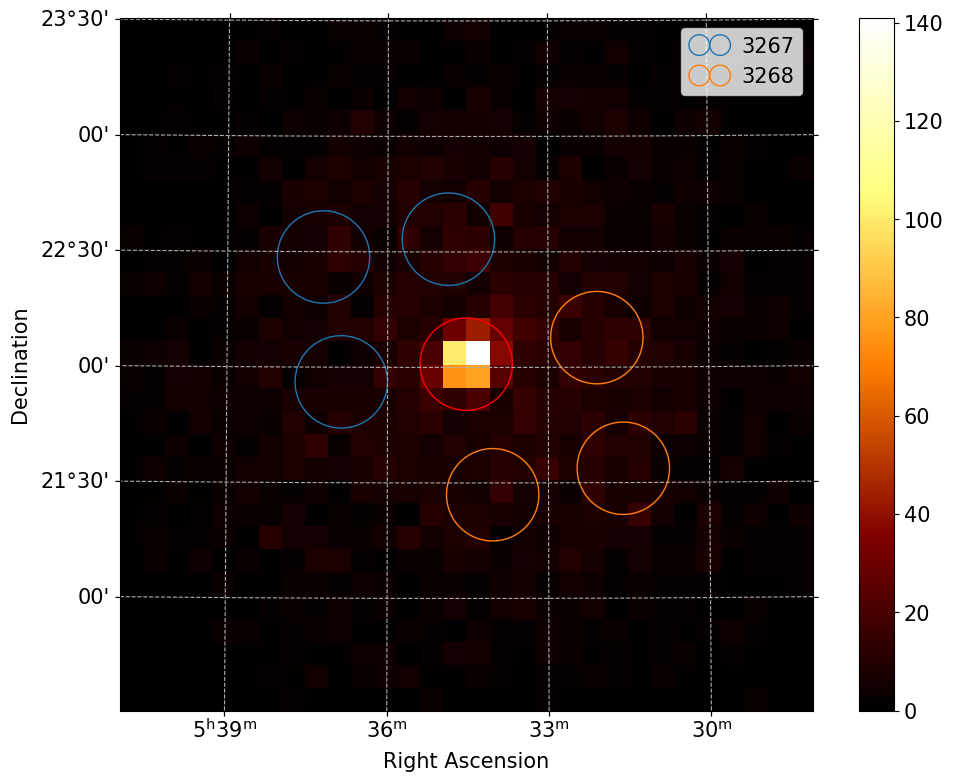

In [9]:
plt.figure()

# Plot the count map
ax = counts.plot(add_cbar=True)

# Plot the ON position
on_geom.plot_region(ax=ax, edgecolor="red")

# Plot the OFF positions (only the first part of observations)
if n_observations < 10:
    plot_spectrum_datasets_off_regions(datasets, ax)
else:
    plot_spectrum_datasets_off_regions(datasets[0:10], ax)

ax.grid()

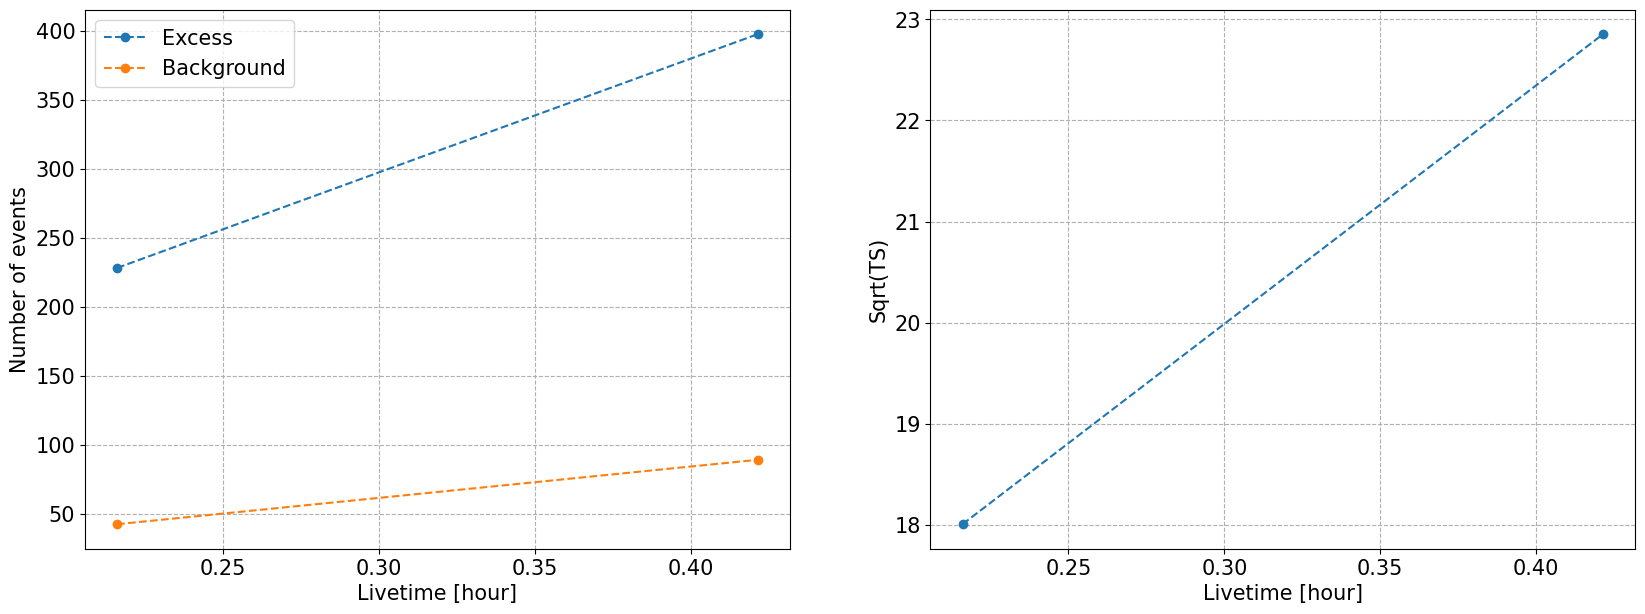

In [10]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

# Fit the spectrum

In [11]:
# ================
# === Settings ===
# ================

source_name = "Crab Nebula"

spectral_model = LogParabolaSpectralModel(
    amplitude=u.Quantity(5e-12, unit="cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=u.Quantity(1, unit="TeV"),
)

# ============
# === Main ===
# ============

sky_model = SkyModel(spectral_model=spectral_model.copy(), name=source_name)

# Add the model to the stacked dataset
stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = [sky_model]

# Fit the spectral model
fit = Fit()

results = fit.run(datasets=stacked_dataset)
print(results)

# Keep the best fit model
best_fit_model = stacked_dataset.models[0].spectral_model.copy()

# Show the fitted parameters
stacked_dataset.models.to_parameters_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 124
	total stat : 2.46

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,2.8230e-11,cm-2 s-1 TeV-1,2.652e-12,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.8032e+00,,1.272e-01,nan,nan,False,False,
Crab Nebula,spectral,beta,2.5197e-01,,8.385e-02,nan,nan,False,False,


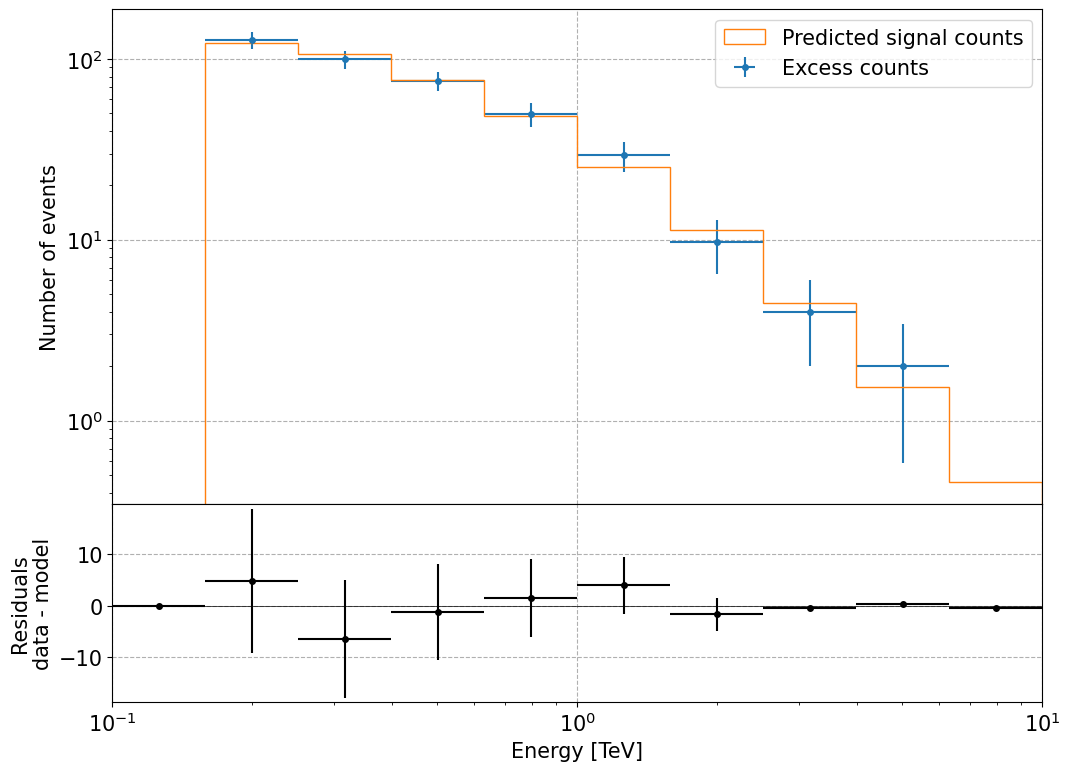

In [12]:
plt.figure()

# Plot the number of excess and predicted events
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

# Estimate the flux points

In [13]:
# Create a flux point estimator
flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source=source_name, selection_optional="all"
)

# Run the flux point estimator to the datasets
print("Running the flux points estimator...")
flux_points = flux_points_estimator.run(datasets=stacked_dataset)

# Show the flux points table
flux_points.to_table(sed_type="e2dnde", formatted=True)

Running the flux points estimator...


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.200,0.158,0.251,5.581e-11,6.124e-12,6.258e-12,6.001e-12,6.865e-11,125.142,11.187,178.8852542085511,127.54094,0.000,False,179.0,True,0.200 .. 5.000,76.031 .. 491.609
0.316,0.251,0.398,4.773e-11,5.448e-12,5.597e-12,5.302e-12,5.922e-11,131.035,11.447,122.01513818109262,99.682724,0.000,False,122.0,True,0.200 .. 5.000,73.044 .. 491.775
0.501,0.398,0.631,4.285e-11,5.275e-12,5.459e-12,5.098e-12,5.415e-11,129.889,11.397,83.98178761308306,75.64785,0.000,False,84.0,True,0.200 .. 5.000,73.192 .. 357.619
0.794,0.631,1.000,3.458e-11,5.247e-12,5.477e-12,5.032e-12,4.603e-11,85.927,9.270,54.95953365004382,49.62489,0.000,False,55.0,True,0.200 .. 5.000,49.941 .. 215.973
1.259,1.000,1.585,2.687e-11,5.146e-12,5.449e-12,4.854e-12,3.840e-11,59.815,7.734,30.999421298791876,29.332745,0.000,False,31.0,True,0.200 .. 5.000,36.918 .. 105.857
1.995,1.585,2.512,1.226e-11,4.033e-12,4.462e-12,3.630e-12,2.208e-11,21.599,4.648,9.99992749126445,9.666594,0.000,False,10.0,True,0.200 .. 5.000,10.713 .. 59.105
3.162,2.512,3.981,7.182e-12,3.591e-12,4.226e-12,3.029e-12,1.699e-11,11.090,3.330,3.987231954797735,3.987232,0.000,False,4.0,True,0.200 .. 5.000,5.749 .. 22.783


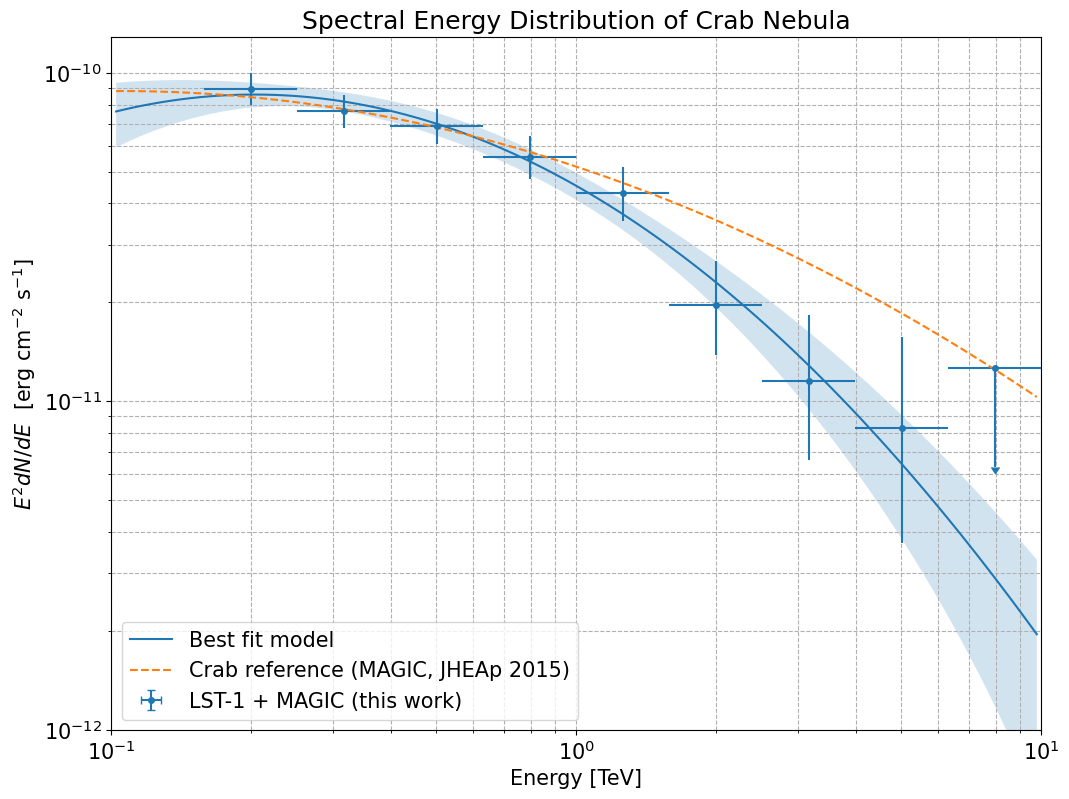

In [14]:
# ================
# === Settings ===
# ================

sed_type = "e2dnde"
yunits = "erg cm-2 s-1"

crab_model = create_crab_spectral_model("magic_lp")

reference_models = {"Crab reference (MAGIC, JHEAp 2015)": crab_model}

# ============
# === Main ===
# ============

plt.figure()

energy_bounds = energy_axis.edges[[0, -1]]

lines = itertools.cycle(["--", "-.", ":"])

# Plot the flux points
ax = flux_points.plot(sed_type=sed_type, label="LST-1 + MAGIC (this work)")

# Plot the best fit model and its error
best_fit_model.plot(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    color=colors[0],
    label="Best fit model",
)

best_fit_model.plot_error(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    facecolor=colors[0],
)

# Plot the reference spectra
for label, model in reference_models.items():

    model.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        label=label,
        linestyle=next(lines),
    )

ax.set_title(f"Spectral Energy Distribution of {source_name}")
ax.set_ylabel("$E^2dN/dE$  [erg cm$^{-2}$ s$^{-1}$]")
ax.set_ylim(1e-12)
ax.grid(which="both")
ax.legend(loc="lower left")

# Estimate the light curve

In [15]:
# ================
# === Settings ===
# ================

frozen_params = ["alpha", "beta"]

# ============
# === Main ===
# ============

sky_model = SkyModel(spectral_model=best_fit_model.copy(), name=source_name)

# Freeze the spectral parameters
for param in frozen_params:
    sky_model.parameters[param].frozen = True

# Add the model to the datasets
datasets.models = [sky_model]

print(sky_model)

SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   2.82e-11   +/- 2.7e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.803                   
    beta                  (frozen):      0.252                   




In [16]:
# ================
# === Settings ===
# ================

energy_edges = energy_axis.edges[[1, -1]]

time_intervals = None  # `None` means "run-wise"

# ============
# === Main ===
# ============

# Create a light curve estimator
light_curve_estimator = LightCurveEstimator(
    energy_edges=energy_edges,
    time_intervals=time_intervals,
    source=source_name,
    selection_optional="all",
)

# Run the light curve estimator to the datasets
print("Running the light curve estimator...")
light_curve = light_curve_estimator.run(datasets=datasets)

# Show the light curve table
light_curve.to_table(sed_type="flux", format="lightcurve")

Running the light curve estimator...


time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,2]","float64[1,2]",float64[1],bool[1],"float64[1,2]",bool[1],"float64[1,11]","float64[1,11]"
59198.916665688004,59198.92610477444,1.2589254117941675,0.1584893192461114,10.000000000000002,3.0467335451989357e-10,2.258836289413402e-11,2.301757976637064e-11,2.2165504420907638e-11,3.5157966990801087e-10,334.814425940081,18.297935018468095,269.8217600302014 .. nan,226.7625274658203 .. nan,4.790330606079054,False,271.0 .. nan,True,0.2 .. 4.999999999999999,209.72504690036877 .. 839.4847530410811
59198.92784154502,59198.93681789442,1.2589254117941675,0.1584893192461114,10.000000000000002,2.4183317684614425e-10,2.1091655211718497e-11,2.1549866432054234e-11,2.0640338984091806e-11,2.858627144535619e-10,236.41542346553135,15.37580643301454,nan .. 217.43201275421148,nan .. 171.24278259277344,4.693992439201683,False,nan .. 216.0,True,0.2 .. 4.999999999999999,131.49268636777464 .. 925.6917941009941


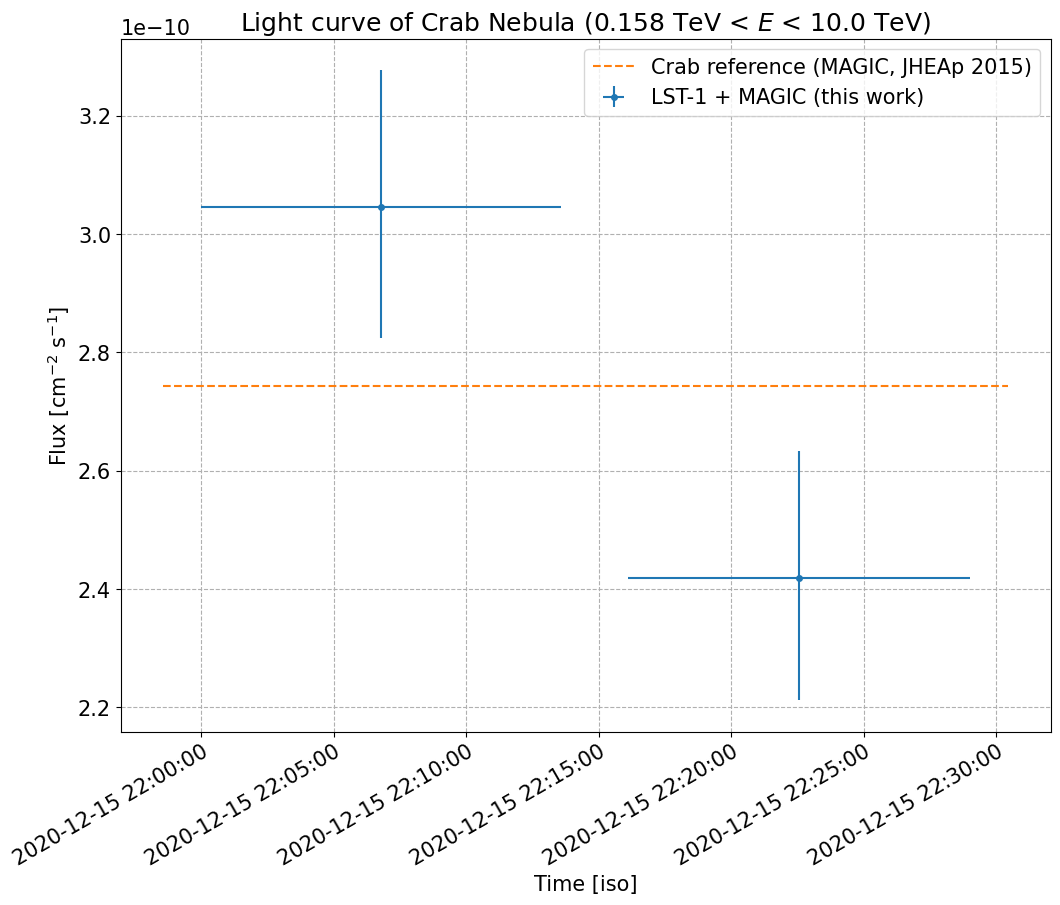

In [17]:
plt.figure()

lines = itertools.cycle(["--", "-.", ":"])

# Plot the light curve
ax = light_curve.plot(sed_type="flux", label="LST-1 + MAGIC (this work)")

xlim = plt.xlim()

# Plot the reference flux
for label, model in reference_models.items():

    integ_flux = model.integral(energy_edges[0], energy_edges[1])
    ax.plot(xlim, np.repeat(integ_flux, 2), label=label, linestyle=next(lines))

energy_range = f"{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}"

ax.set_title(f"Light curve of {source_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_yscale("linear")
ax.legend()
ax.grid()